In [1]:
import os

import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import scipy
import scipy.stats
import seaborn

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Combined replicates
datasets = [
    {
        'short_label': 'F25-N50',
        'filepath': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'seq_len': 50,
        'const_prefix_len': 25,
        'color': '#009444',
        'linestyle': '-',
        'cols': ['utr', 'total_reads', 'rl'],
    },
    {
        'short_label': 'G3-N25',
        'filepath': '../polysome_profiling_data/random_end_hek293t_N25_combined.csv.gz',
        'seq_len': 25,
        'const_prefix_len': 3,
        'color': '#FBB040',
        'linestyle': '-',
        'cols': ['UTR', 'total', 'rl'],
    },
    {
        'short_label': 'G3-N50',
        'filepath': '../polysome_profiling_data/random_end_hek293t_N50_r1.csv.gz',
        'seq_len': 50,
        'const_prefix_len': 3,
        'color': '#F15A29',
        'linestyle': '-',
        'cols': ['UTR', 'total', 'rl'],
    },
]

In [4]:
# Load data
for dataset in datasets:
    
    data_table = pandas.read_csv(
        dataset['filepath'],
        usecols=dataset['cols'],
    )
    data_table = data_table.rename(columns={'utr': 'UTR', 'total_reads': 'total'})
    data_table = data_table[data_table['total'] > 100]
    
    dataset['data_table'] = data_table

In [5]:
# Extract reads with a start codon at each position, calculate mean MRL
for dataset in datasets:
    mrl_mean_dataset = {}
    mrl_std_dataset = {}
    mrl_median_dataset = {}
    mrl_mean_dataset['atg'] = []
    mrl_mean_dataset['ctg'] = []
    mrl_mean_dataset['gtg'] = []
    mrl_std_dataset['atg'] = []
    mrl_std_dataset['ctg'] = []
    mrl_std_dataset['gtg'] = []
    mrl_median_dataset['atg'] = []
    mrl_median_dataset['ctg'] = []
    mrl_median_dataset['gtg'] = []
    data_table = dataset['data_table']
    for pos in range(dataset['seq_len'] - 2):
        atg_table = data_table[data_table['UTR'].apply(lambda x: 'ATG' in x[pos:pos+3])]
        ctg_table = data_table[data_table['UTR'].apply(lambda x: 'CTG' in x[pos:pos+3])]
        gtg_table = data_table[data_table['UTR'].apply(lambda x: 'GTG' in x[pos:pos+3])]
        mrl_mean_dataset['atg'].append(atg_table['rl'].mean())
        mrl_mean_dataset['ctg'].append(ctg_table['rl'].mean())
        mrl_mean_dataset['gtg'].append(gtg_table['rl'].mean())
        mrl_std_dataset['atg'].append(atg_table['rl'].std())
        mrl_std_dataset['ctg'].append(ctg_table['rl'].std())
        mrl_std_dataset['gtg'].append(gtg_table['rl'].std())
        mrl_median_dataset['atg'].append(atg_table['rl'].median())
        mrl_median_dataset['ctg'].append(ctg_table['rl'].median())
        mrl_median_dataset['gtg'].append(gtg_table['rl'].median())
        
    dataset['mrl_uatg_mean'] = numpy.array(mrl_mean_dataset['atg'])
    dataset['mrl_uctg_mean'] = numpy.array(mrl_mean_dataset['ctg'])
    dataset['mrl_ugtg_mean'] = numpy.array(mrl_mean_dataset['gtg'])
    dataset['mrl_uatg_std'] = numpy.array(mrl_std_dataset['atg'])
    dataset['mrl_uctg_std'] = numpy.array(mrl_std_dataset['ctg'])
    dataset['mrl_ugtg_std'] = numpy.array(mrl_std_dataset['gtg'])
    dataset['mrl_uatg_median'] = numpy.array(mrl_median_dataset['atg'])
    dataset['mrl_uctg_median'] = numpy.array(mrl_median_dataset['ctg'])
    dataset['mrl_ugtg_median'] = numpy.array(mrl_median_dataset['gtg'])
    dataset['ustart_pos_cds'] = numpy.arange(dataset['seq_len'] - 2) - dataset['seq_len']
    dataset['ustart_pos_mrna'] = numpy.arange(dataset['seq_len'] - 2) + 1 + dataset['const_prefix_len']

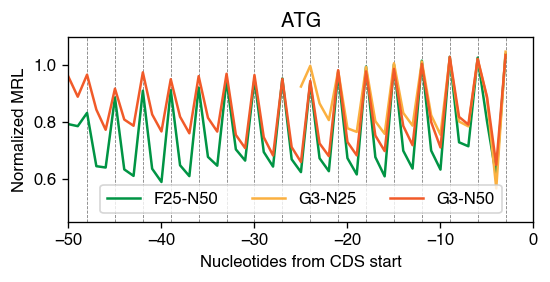

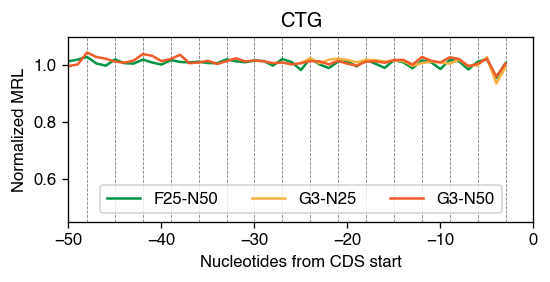

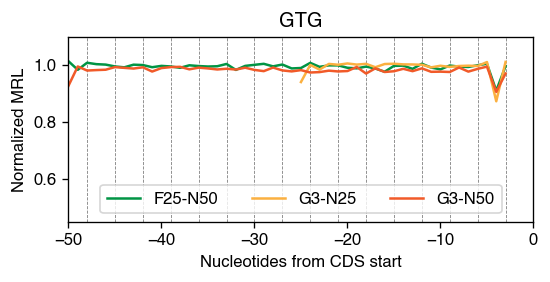

In [6]:
# Plot MRL with ATG coordinates
for ustart in ['atg', 'ctg', 'gtg']:
    fig, ax = pyplot.subplots(figsize=(5, 2.))

    for dataset in datasets:
        ax.plot(
            dataset['ustart_pos_cds'],
            dataset['mrl_u' + ustart + '_median']/dataset['data_table']['rl'].median(),
            label=dataset['short_label'],
            color=dataset['color'],
            linestyle=dataset['linestyle'],
        )

    ax.set_xlim(-50, 0)
    ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
    ax.set_xlabel('Nucleotides from CDS start')
    ax.set_ylabel('Normalized MRL')
    ax.set_ylim(0.45, 1.1)

    for x in numpy.arange(0, -50, -3):
        ax.axvline(x=x, linestyle='--', color='gray', lw=0.5, zorder=-1)

    ax.legend(ncol=len(datasets), loc='lower center')
    ax.set_title(ustart.upper())

    fig.savefig(f'norm_mrl_u' + ustart + '_cds.svg', dpi=200, bbox_inches='tight')

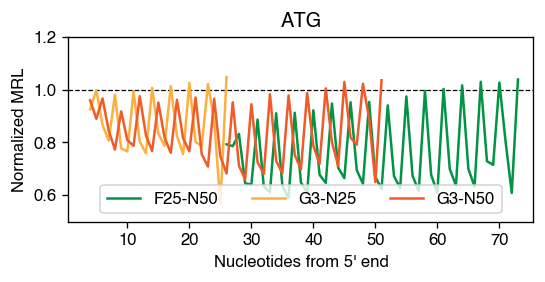

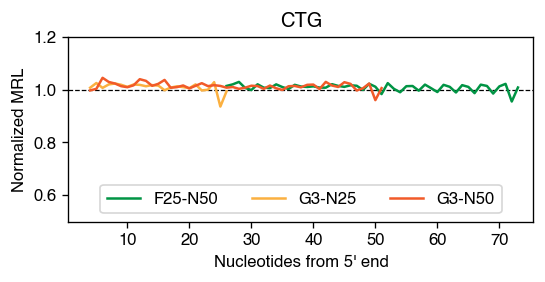

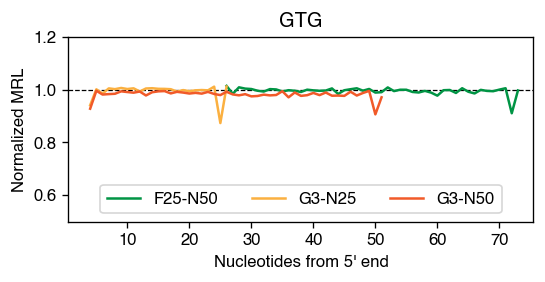

In [7]:
# Plot MRL with ATG coordinates
for ustart in ['atg', 'ctg', 'gtg']:
    fig, ax = pyplot.subplots(figsize=(5, 2.))

    for dataset in datasets:
        ax.plot(
            dataset['ustart_pos_mrna'],
            dataset['mrl_u' + ustart + '_median']/dataset['data_table']['rl'].median(),
            label=dataset['short_label'],
            color=dataset['color'],
            linestyle=dataset['linestyle'],
        )
    ax.axhline(1, color='black', linestyle='--', linewidth=0.75, zorder=-1)

    ax.set_xlim(0.5, 75.5)
    ax.xaxis.set_major_locator(pyplot.MultipleLocator(base=10))
    ax.set_xlabel('Nucleotides from 5\' end')
    ax.set_ylabel('Normalized MRL')
    ax.set_ylim(0.5, 1.2)

    # for x in numpy.arange(0, -50, -3):
    #     ax.axvline(x=x, linestyle='--', lw=0.5)

    ax.legend(ncol=len(datasets), loc='lower center')
    ax.set_title(ustart.upper())

    fig.savefig(f'norm_mrl_u' + ustart + '_mrna.svg', dpi=200, bbox_inches='tight')